This is a simple, supervised denoising model run on ImageNet. This code is essentially identical to `n2n_imagenet.ipynb` except it uses `SupervisedDenoisingGenerator` for both training and testing.

In [1]:
import numpy as np
import keras
from importlib import reload
import os

from helpers import generators, utils, noise_models
from models import unet_n2n, irfan_2020

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

utils.check_gpu_use()

GPU DETECTED ✓
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
!pip show tensorflow 

Name: tensorflow
Version: 2.13.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/antrikshdhand/Documents/github/thesis-ml/ml/virt/lib/python3.9/site-packages
Requires: tensorflow-macos
Required-by: 


In [4]:
reload(generators)
reload(utils)
reload(noise_models)

<module 'helpers.noise_models' from '/Users/antrikshdhand/Documents/github/thesis-ml/ml/main/helpers/noise_models.py'>

In [5]:
np.random.seed(42)

## Initialise data

In [6]:
TRAIN_IMAGE_DIR = "../../raw_datasets/imagenet-10k"
VAL_IMAGE_DIR = "../../raw_datasets/BSDS300/images/train"
TEST_IMAGE_DIR = "../../raw_datasets/BSDS300/images/test"

NUM_EPOCHS = 50
GPU_BATCH_SIZE = 4
DATA_BATCH_SIZE = 16

In [7]:
noise_model = noise_models.gaussian_noise

In [8]:
train_gen = generators.SupervisedDenoisingGenerator(
    image_dir=TRAIN_IMAGE_DIR,
    noise_model=noise_model,
    batch_size=DATA_BATCH_SIZE,
    patch_edge_size=192,
    zero_one_normalisation=True,
    greyscale=True
)

val_gen = generators.SupervisedDenoisingGenerator(
    image_dir=VAL_IMAGE_DIR,
    noise_model=noise_model,
    batch_size=DATA_BATCH_SIZE,
    patch_edge_size=192,
    zero_one_normalisation=True,
    greyscale=True
)

test_gen = generators.SupervisedDenoisingGenerator(
    image_dir=TEST_IMAGE_DIR,
    noise_model=noise_model,
    batch_size=DATA_BATCH_SIZE,
    patch_edge_size=192,
    zero_one_normalisation=True,
    greyscale=True
)

## Initialise model

In [9]:
model = irfan_2020.get_irfan_model(input_shape=(192, 192, 1))
# model = unet_n2n.get_unet_model(input_shape=(192, 192, 1))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.99, epsilon=1e-8),
    loss=keras.losses.MeanSquaredError(),
    metrics=[utils.psnr, utils.ssim],
)

model.summary()

Model: "irfan_2020"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 192, 192, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 192, 192, 64)      640       
                                                                 
 activation (Activation)     (None, 192, 192, 64)      0         
                                                                 
 batch_normalization (Batch  (None, 192, 192, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 96, 96, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        3

## Train model

In [10]:
csv_logger = keras.callbacks.CSVLogger(
    filename="models/saved/supervised_denoiser_07122024/irfan/training.log",
    separator=',',
    append=False
)

backup_callback = keras.callbacks.BackupAndRestore(
    backup_dir="models/saved/supervised_denoiser_07122024/irfan/tmp"
)

In [11]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    batch_size=GPU_BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=2,
    callbacks=[csv_logger, backup_callback]
)

Epoch 1/50
625/625 - 159s - loss: 0.0280 - psnr: 16.3487 - ssim: 0.3819 - val_loss: 0.0176 - val_psnr: 18.2082 - val_ssim: 0.4148 - 159s/epoch - 255ms/step
Epoch 2/50
625/625 - 160s - loss: 0.0182 - psnr: 18.1963 - ssim: 0.4263 - val_loss: 0.0137 - val_psnr: 19.5573 - val_ssim: 0.4393 - 160s/epoch - 256ms/step
Epoch 3/50
625/625 - 160s - loss: 0.0167 - psnr: 18.6549 - ssim: 0.4378 - val_loss: 0.0127 - val_psnr: 19.9574 - val_ssim: 0.4463 - 160s/epoch - 257ms/step
Epoch 4/50
625/625 - 157s - loss: 0.0154 - psnr: 19.0410 - ssim: 0.4452 - val_loss: 0.0120 - val_psnr: 20.0944 - val_ssim: 0.4626 - 157s/epoch - 252ms/step
Epoch 5/50
625/625 - 156s - loss: 0.0148 - psnr: 19.2679 - ssim: 0.4515 - val_loss: 0.0120 - val_psnr: 20.0646 - val_ssim: 0.4552 - 156s/epoch - 249ms/step
Epoch 6/50
625/625 - 156s - loss: 0.0145 - psnr: 19.3932 - ssim: 0.4545 - val_loss: 0.0112 - val_psnr: 20.6805 - val_ssim: 0.4771 - 156s/epoch - 249ms/step
Epoch 7/50
625/625 - 156s - loss: 0.0136 - psnr: 19.6687 - ssim:

In [12]:
model.save("models/saved/supervised_denoiser_07122024/irfan/50epochs.keras")
# model.save("models/saved/supervised_denoiser_07122024/unet/50epochs.keras")

/var/folders/6d/6rll4yfx64n5s_34fjy87zd80000gn/T/ipykernel_98625/3341100829.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  together.show()


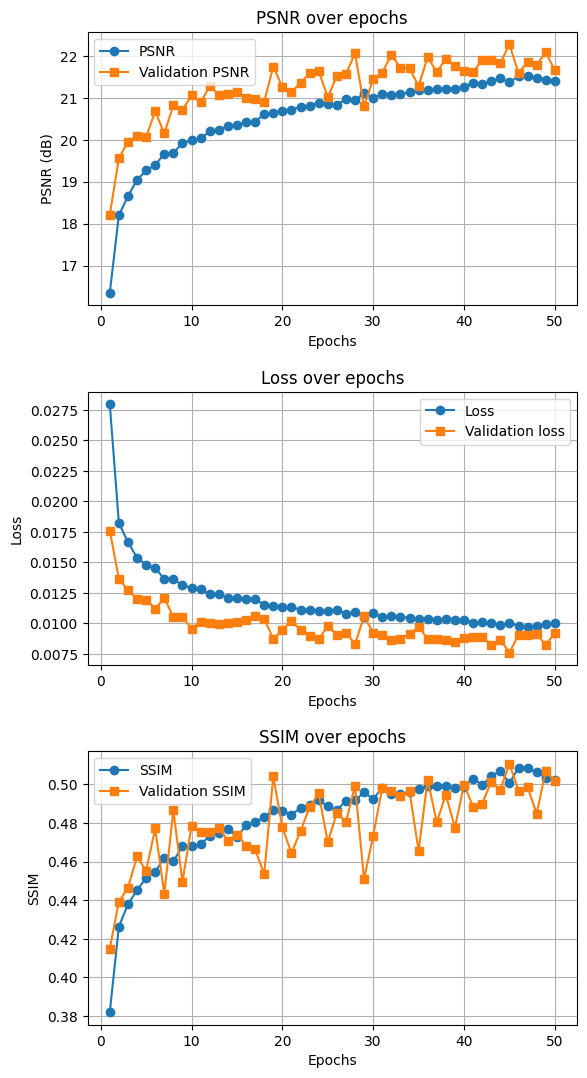

In [13]:
reload(utils)

together = utils.get_psnr_and_loss_curves(history, together=True, ssim=True)
together.savefig('models/saved/supervised_denoiser_07122024/irfan/img/psnr_loss.pdf')
# together.savefig('models/saved/supervised_denoiser_07122024/unet/img/psnr_loss.pdf')
together.show()

## Evaluate model

In [14]:
evals = model.evaluate(
    test_gen,
    batch_size=GPU_BATCH_SIZE,
    verbose=2
)

6/6 - 0s - loss: 0.0094 - psnr: 21.4837 - ssim: 0.4556 - 306ms/epoch - 51ms/step


In [15]:
evals

[0.009444857947528362, 21.48371124267578, 0.4556431472301483]

1/1 [==============================] - 0s 275ms/step


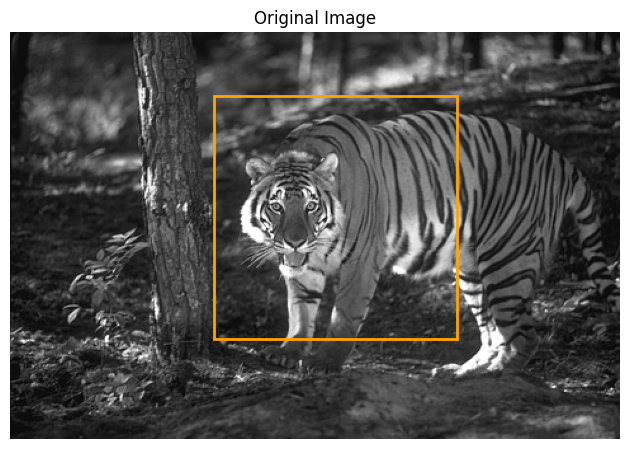

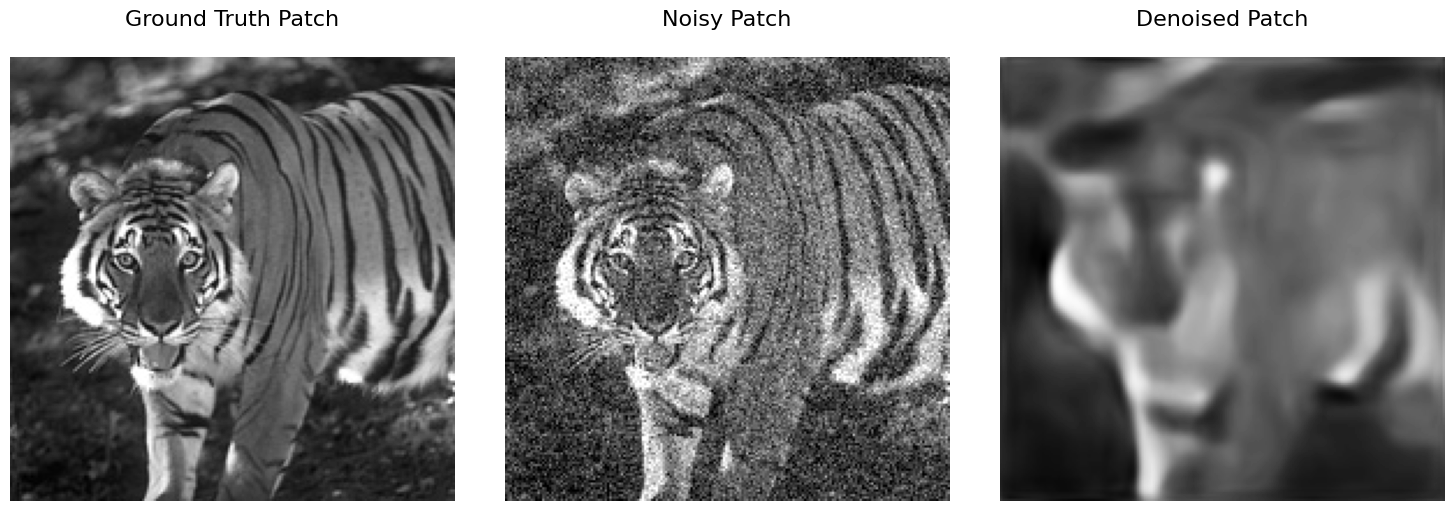

In [16]:
ground_truth_fig, patches_fig = utils.test_model_on_image(
    image_path=TEST_IMAGE_DIR + "/108005.jpg", 
    model=model,
    patch_size=192, 
    zero_one_normalisation=True, 
    greyscale=True,
    stddev=30,
    patch_coords=(160, 50)
)

ground_truth_fig.savefig('models/saved/supervised_denoiser_07122024/irfan/img/ground_truth_fig_1.pdf')
patches_fig.savefig('models/saved/supervised_denoiser_07122024/irfan/img/patches_fig_1.pdf')

# ground_truth_fig.savefig('models/saved/supervised_denoiser_07122024/unet/img/ground_truth_fig_1.pdf')
# patches_fig.savefig('models/saved/supervised_denoiser_07122024/unet/img/patches_fig_1.pdf')

1/1 [==============================] - 0s 28ms/step


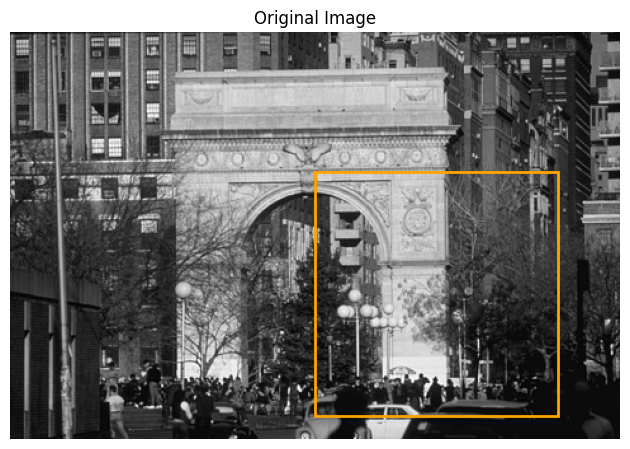

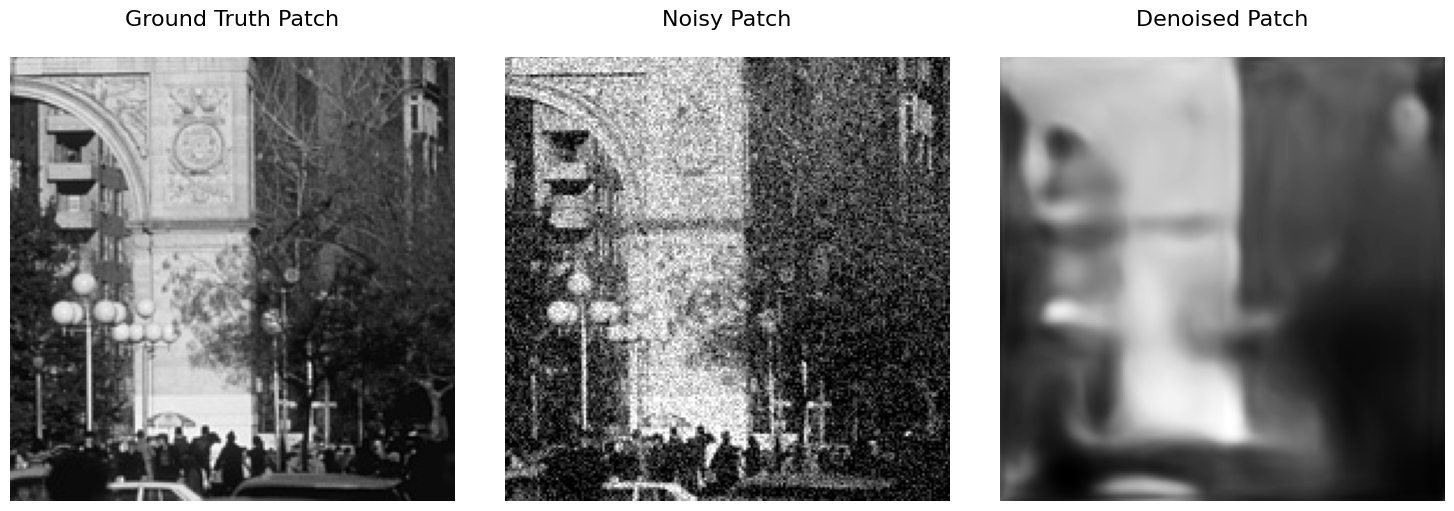

In [17]:
ground_truth_fig, patches_fig = utils.test_model_on_image(
    image_path=TEST_IMAGE_DIR + "/148089.jpg", 
    model=model,
    patch_size=192, 
    zero_one_normalisation=True, 
    greyscale=True,
    stddev=30,
    patch_coords=(240, 110)
)

ground_truth_fig.savefig('models/saved/supervised_denoiser_07122024/irfan/img/ground_truth_fig_2.pdf')
patches_fig.savefig('models/saved/supervised_denoiser_07122024/irfan/img/patches_fig_2.pdf')

# ground_truth_fig.savefig('models/saved/supervised_denoiser_07122024/unet/img/ground_truth_fig_2.pdf')
# patches_fig.savefig('models/saved/supervised_denoiser_07122024/unet/img/patches_fig_2.pdf')